# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:12<00:00, 4.80KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

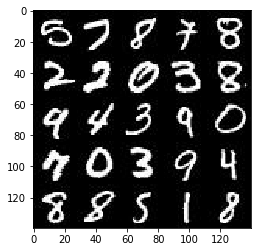

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

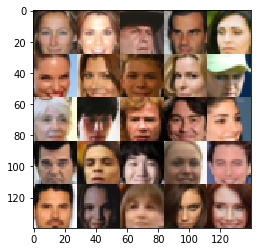

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(
        tf.float32, 
        shape = [None, image_height, image_width, image_channels], 
        name = 'real_input_images'
    )
    
    z_data = tf.placeholder(
        tf.float32,
        shape = [None, z_dim],
        name = 'z_data'
    )
    
    learning_rate = tf.placeholder(
        tf.float32,
        shape = [],
        name = 'learning_rate'
    )
    
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [135]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Note this code block largely reproduced from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*128))
        # h1 = tf.layers.dense(flat, 4096, activation = None)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        # print("images input shape", images.shape)
        # print("x1 shape", x1.shape)
        # print("x2 shape", x2.shape)
        # print("x3 shape", x3.shape)
        # print("flat shape", flat.shape)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [136]:
def generator(input_z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Note this code block largely reproduced from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn 
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(input_z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        #x2 = tf.reshape(x1, (-1, 7, 7, 128))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        #x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        #x4 = tf.layers.batch_normalization(x4, training=is_train)
        #x4 = tf.maximum(alpha * x4, x4)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x out_channel_dim now
        
        out = tf.tanh(logits)
        
        #print("input_z shape",input_z.shape)
        #print("x1 shape", x1.shape)
        #print("x2 shape", x2.shape)
        #print("x3 shape", x3.shape)
        #####3#print("x4 shape", x4.shape)
        #print("logits shape", logits.shape)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [137]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Note this code block largely reproduced from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn
    g_image = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_image, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [138]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Note this code block reproduced in entirety from 
    # https://github.com/udacity/deep-learning/tree/master/dcgan-svhn

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [139]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [140]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    # print("input_real shape",input_real.shape)
    # print("input_z shape", input_z.shape)
    # print("output_channel_dim", data_shape[3])
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
               
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # print losses every 10 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # show generator output every 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.2035
Epoch 1/2... Discriminator Loss: 1.9668... Generator Loss: 0.3675
Epoch 1/2... Discriminator Loss: 2.3650... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.5758... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.6005
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.5121... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.5628
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.6444


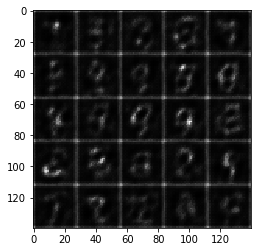

Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.5848... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 1.8891... Generator Loss: 0.2225
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.2208... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 1.0904


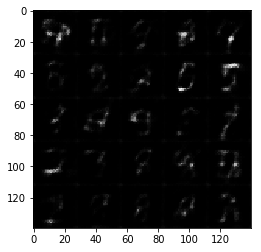

Epoch 1/2... Discriminator Loss: 1.6492... Generator Loss: 0.3195
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.5424... Generator Loss: 0.3585
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 1.0972
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.4082... Generator Loss: 0.4834
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.5683


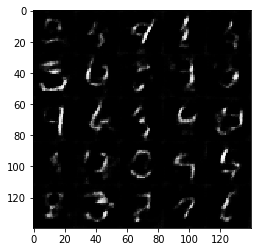

Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 1.2031
Epoch 1/2... Discriminator Loss: 1.4722... Generator Loss: 0.3541
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.4515
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.5592
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.2083
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.8593


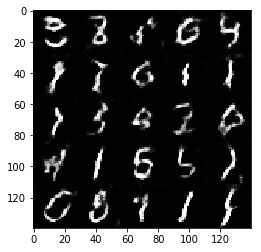

Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.2280... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 1.1752
Epoch 1/2... Discriminator Loss: 1.2259... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.9811


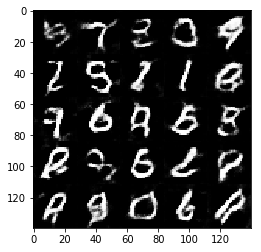

Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.9819
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.4987
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.4628... Generator Loss: 0.3609
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.5099
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 1.1862


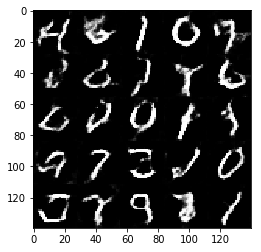

Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.3898
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.5097
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.9128
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 0.7314


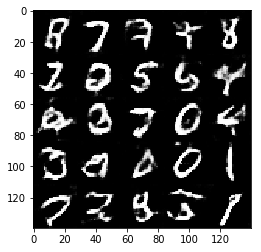

Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.4806
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 1.3061
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.1418
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 1.0407


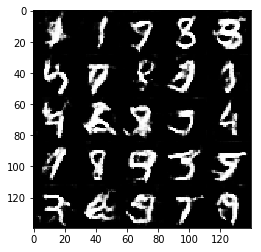

Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.8772... Generator Loss: 0.2361
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.7310
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.1943
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 0.3656
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 0.9829... Generator Loss: 1.0182
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.5285


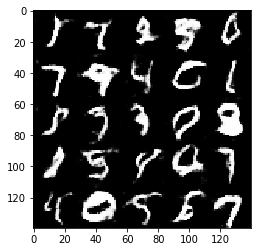

Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 1.5807
Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.5172
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.5534... Generator Loss: 0.3169
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 1.5588
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 0.6924


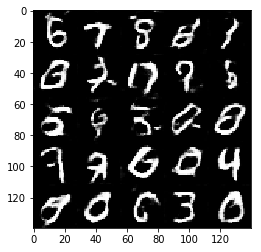

Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.1927
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.1791... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 1.1219
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 0.6512
Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 0.5928


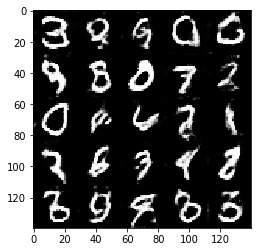

Epoch 1/2... Discriminator Loss: 0.9835... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 1.2646
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 1.3368
Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.3042
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.4878... Generator Loss: 0.3702
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.9637


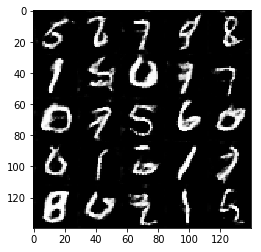

Epoch 1/2... Discriminator Loss: 1.4864... Generator Loss: 0.3631
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.5189
Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 0.9673
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 1.1431
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 0.6915
Epoch 1/2... Discriminator Loss: 0.8228... Generator Loss: 1.2587
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 0.7946... Generator Loss: 1.5241
Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 1.0424


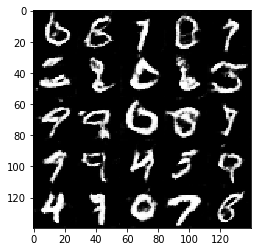

Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.4766
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.0339
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 0.7138
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 0.8333
Epoch 1/2... Discriminator Loss: 0.5970... Generator Loss: 1.4493
Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 0.8927
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.5225... Generator Loss: 0.3247
Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 0.6373


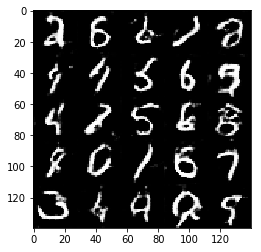

Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 1.0247
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 1.4727
Epoch 1/2... Discriminator Loss: 0.9378... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.0526
Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 1.4146
Epoch 1/2... Discriminator Loss: 1.4954... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.7522


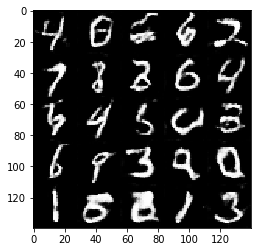

Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 2.4027
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 1.4287
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 0.8084
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.6196
Epoch 1/2... Discriminator Loss: 0.6066... Generator Loss: 1.6512
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 0.7418... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 1.4615... Generator Loss: 0.3617


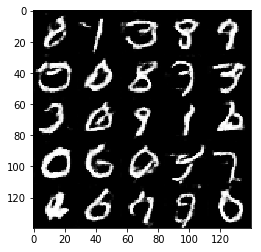

Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 1.6602
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.4851
Epoch 1/2... Discriminator Loss: 0.8266... Generator Loss: 1.4669
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 0.9058
Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 1.5314
Epoch 1/2... Discriminator Loss: 0.7233... Generator Loss: 1.5313
Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 1.2319... Generator Loss: 0.6457


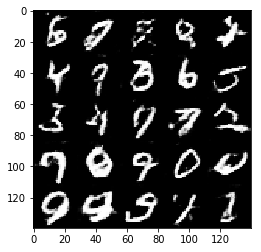

Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 0.6098... Generator Loss: 1.2666
Epoch 1/2... Discriminator Loss: 0.7617... Generator Loss: 1.4214
Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 1.8830... Generator Loss: 0.2571
Epoch 1/2... Discriminator Loss: 0.7334... Generator Loss: 1.1825


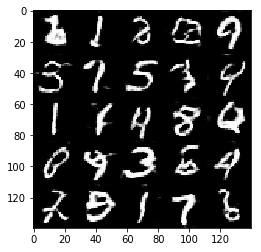

Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 0.9112
Epoch 1/2... Discriminator Loss: 0.4581... Generator Loss: 1.4781
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 0.9789
Epoch 1/2... Discriminator Loss: 1.6744... Generator Loss: 3.7458
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.4818
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 1.2002
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 0.7677


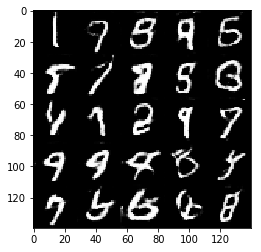

Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 0.4613... Generator Loss: 1.8524
Epoch 2/2... Discriminator Loss: 0.6335... Generator Loss: 1.1692
Epoch 2/2... Discriminator Loss: 1.8289... Generator Loss: 0.2721
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 1.6770
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 1.0694
Epoch 2/2... Discriminator Loss: 0.9605... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.0949
Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.0545


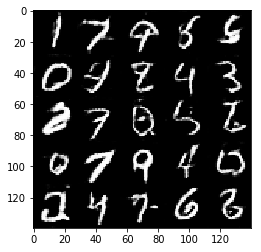

Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 1.5533
Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 1.6706
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 0.7993
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 1.1415
Epoch 2/2... Discriminator Loss: 1.5146... Generator Loss: 0.3917
Epoch 2/2... Discriminator Loss: 0.4555... Generator Loss: 1.6981
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 0.5941... Generator Loss: 1.6891


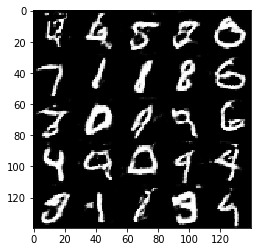

Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.6284
Epoch 2/2... Discriminator Loss: 0.7971... Generator Loss: 0.9348
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.4267
Epoch 2/2... Discriminator Loss: 2.0222... Generator Loss: 0.1911
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 2.1548
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 0.7986
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.0389
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 0.8376


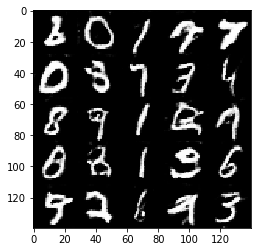

Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.0912
Epoch 2/2... Discriminator Loss: 0.3003... Generator Loss: 2.4224
Epoch 2/2... Discriminator Loss: 0.2979... Generator Loss: 2.1820
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 0.6708... Generator Loss: 1.0260
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 0.6347
Epoch 2/2... Discriminator Loss: 0.8115... Generator Loss: 2.7515
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 2.8477
Epoch 2/2... Discriminator Loss: 1.4470... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 0.9788


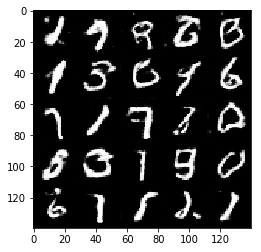

Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 1.7032
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 0.6682... Generator Loss: 1.4458
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.3620
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.9080
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 0.7505


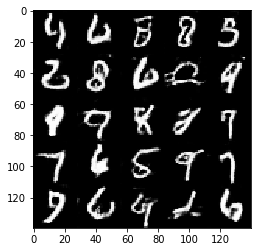

Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.2107
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.3821
Epoch 2/2... Discriminator Loss: 1.2519... Generator Loss: 0.4906
Epoch 2/2... Discriminator Loss: 0.6236... Generator Loss: 1.6626
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 0.9656
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 0.7455... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 0.9536
Epoch 2/2... Discriminator Loss: 0.9099... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 0.8426


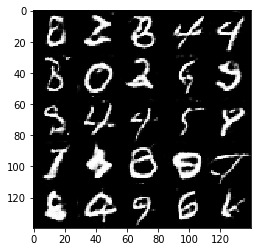

Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 3.7887
Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 0.8904
Epoch 2/2... Discriminator Loss: 0.4555... Generator Loss: 2.6590
Epoch 2/2... Discriminator Loss: 0.5908... Generator Loss: 1.7709
Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 1.4380... Generator Loss: 0.3816
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 1.3166
Epoch 2/2... Discriminator Loss: 1.7533... Generator Loss: 0.3768
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.6104


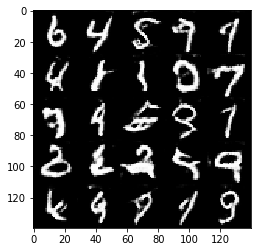

Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 3.1305
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 1.5600... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 1.2027
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 0.4371... Generator Loss: 1.7470
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 1.2686
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 1.7713


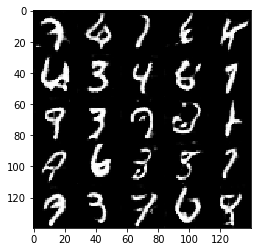

Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 0.4622... Generator Loss: 2.1655
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.3746
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 3.3407
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 1.6423... Generator Loss: 0.4172
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 1.5739
Epoch 2/2... Discriminator Loss: 0.6464... Generator Loss: 2.7496
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.1528


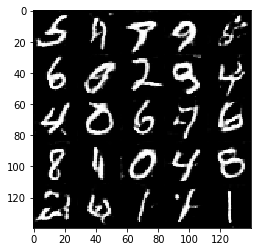

Epoch 2/2... Discriminator Loss: 0.7140... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 1.6093... Generator Loss: 0.3450
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.5526... Generator Loss: 0.4379
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 2.2547
Epoch 2/2... Discriminator Loss: 0.7530... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 0.5424... Generator Loss: 1.3429
Epoch 2/2... Discriminator Loss: 0.4491... Generator Loss: 1.6379
Epoch 2/2... Discriminator Loss: 0.4800... Generator Loss: 1.5120
Epoch 2/2... Discriminator Loss: 0.7982... Generator Loss: 0.8893


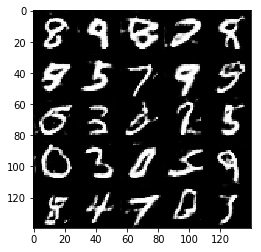

Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.2969
Epoch 2/2... Discriminator Loss: 0.6062... Generator Loss: 1.0611
Epoch 2/2... Discriminator Loss: 2.1987... Generator Loss: 0.2806
Epoch 2/2... Discriminator Loss: 0.5880... Generator Loss: 1.4183
Epoch 2/2... Discriminator Loss: 0.8083... Generator Loss: 0.9985
Epoch 2/2... Discriminator Loss: 1.7608... Generator Loss: 0.4111
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 0.5588... Generator Loss: 1.5035
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 3.3487


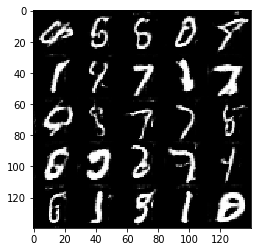

Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 1.7878
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.4389
Epoch 2/2... Discriminator Loss: 1.5120... Generator Loss: 0.3880
Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 1.8655
Epoch 2/2... Discriminator Loss: 0.8163... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 1.5538
Epoch 2/2... Discriminator Loss: 0.4939... Generator Loss: 1.3045


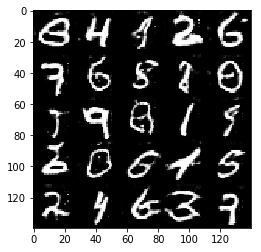

Epoch 2/2... Discriminator Loss: 0.2485... Generator Loss: 2.3282
Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 1.0970
Epoch 2/2... Discriminator Loss: 0.5754... Generator Loss: 1.8150
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 0.8124
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.6015
Epoch 2/2... Discriminator Loss: 0.7608... Generator Loss: 1.0632
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 0.5893
Epoch 2/2... Discriminator Loss: 0.4477... Generator Loss: 1.9740
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 0.8917
Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 3.0488


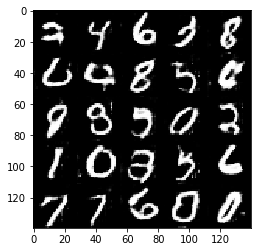

Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 0.4820... Generator Loss: 2.3788
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 0.7711
Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 0.3719... Generator Loss: 1.7718
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 0.3575... Generator Loss: 1.7763
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 0.3052... Generator Loss: 2.4999
Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 0.9809


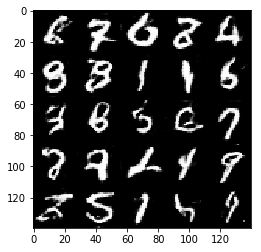

Epoch 2/2... Discriminator Loss: 0.5684... Generator Loss: 1.2525
Epoch 2/2... Discriminator Loss: 0.6224... Generator Loss: 1.2936
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 0.4749... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 0.9606... Generator Loss: 2.5969
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 2.8792
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 1.6936
Epoch 2/2... Discriminator Loss: 0.5387... Generator Loss: 1.5555
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.5073
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.7583


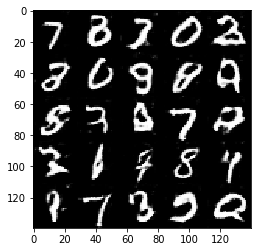

Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 0.3487... Generator Loss: 2.0772
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 2.2136
Epoch 2/2... Discriminator Loss: 0.6533... Generator Loss: 1.3424
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.0077
Epoch 2/2... Discriminator Loss: 0.4794... Generator Loss: 1.4133
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.2309


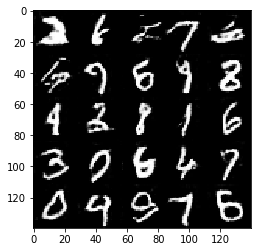

Epoch 2/2... Discriminator Loss: 0.6011... Generator Loss: 1.9008
Epoch 2/2... Discriminator Loss: 0.2666... Generator Loss: 2.0893
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 0.4958... Generator Loss: 1.2839
Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 0.5462
Epoch 2/2... Discriminator Loss: 0.4702... Generator Loss: 1.7147
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 1.0353
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.4863
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 1.4372


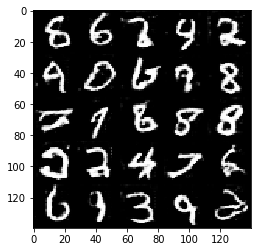

Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.7393
Epoch 2/2... Discriminator Loss: 1.2165... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 1.8863... Generator Loss: 0.3127
Epoch 2/2... Discriminator Loss: 0.7192... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 0.4939... Generator Loss: 2.6483
Epoch 2/2... Discriminator Loss: 0.4665... Generator Loss: 2.3173
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.0859
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 1.1046


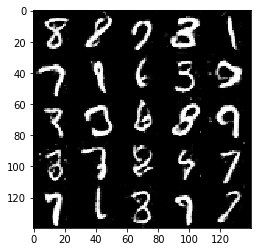

Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.0393
Epoch 2/2... Discriminator Loss: 0.5460... Generator Loss: 1.2291
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 1.8996... Generator Loss: 0.2901


In [142]:
# training nicely
# upped layer filter numbers by *2

# tried adding 4 hidden layers cascading down in length by half.  
# didn't put sigmoid.  training time substantially increased.
# result: images look like weird splotchy artifact not making numbers at all even after 600 steps

# added sigmoid, training seems to have gotten stuck on a noise pattern

# try only one added hidden layer with sigmoid.  
# discriminator converges now and generator generates 
# consistent pattern of noise that isn't learning

# removing sigmoid from hidden layer.  strangely discriminator loss starts at 0 and stays.
# hidden layer seems to be adding this waveform pattern that's causing problems.
# removing.

# keeping 128 256 512 filters
# seems to have artifact now where only top corners are white everything else black

# doubling learning_rate to 0.01

# trying dividing filter stack depths by 2 for 32 62 128 and batch 32
# that worked really well.  images looking pretty good now.
# decreasing learning_rate to 0.001

batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 5.2135
Epoch 1/1... Discriminator Loss: 2.1011... Generator Loss: 0.2636
Epoch 1/1... Discriminator Loss: 1.7863... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.8983
Epoch 1/1... Discriminator Loss: 3.2561... Generator Loss: 0.0590
Epoch 1/1... Discriminator Loss: 2.0878... Generator Loss: 0.1862
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 2.1874
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 2.2553... Generator Loss: 7.5116
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 1.6733


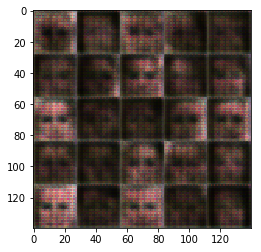

Epoch 1/1... Discriminator Loss: 0.2225... Generator Loss: 4.6968
Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 2.1006
Epoch 1/1... Discriminator Loss: 0.8399... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 0.2136... Generator Loss: 2.1531
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 1.9966
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 2.1506... Generator Loss: 0.2201
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 2.1916... Generator Loss: 0.2209
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.8069


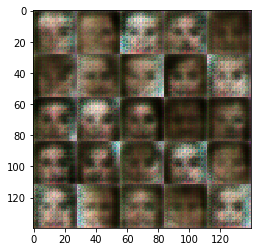

Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.9989
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.9255... Generator Loss: 0.2145
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 2.4658
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.1945


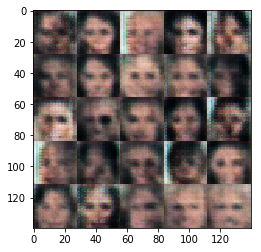

Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.9930... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 3.7125... Generator Loss: 3.4188
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.6897


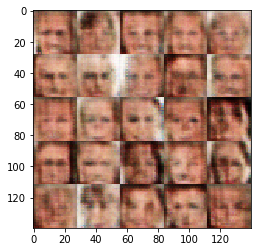

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.8533


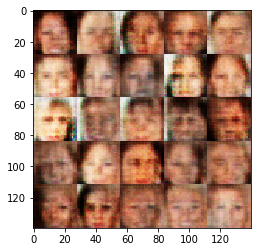

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.8296... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.2482
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.6806


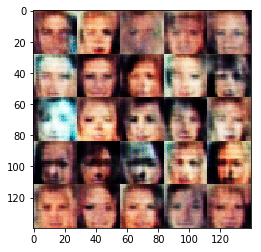

Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.3871
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.4267
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.7903


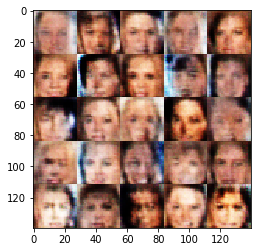

Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.6413... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 1.6593... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8059


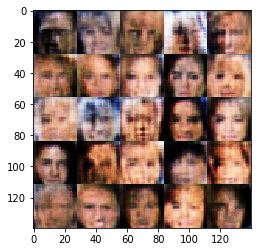

Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.5134


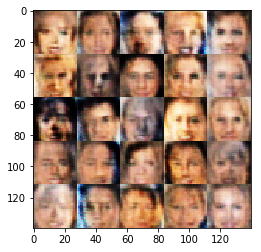

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9929


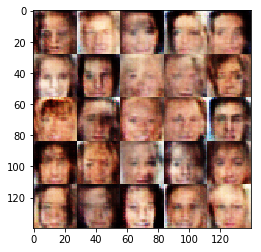

Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6396


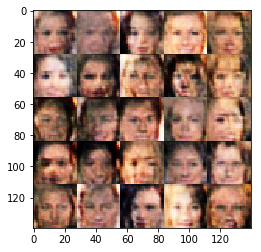

Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.9208


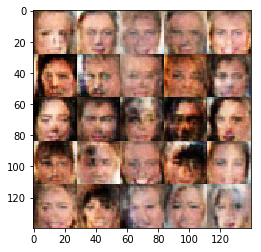

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.5530


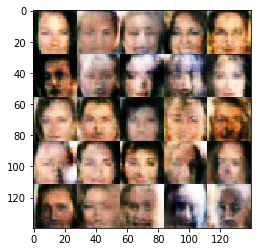

Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 0.3099
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7866


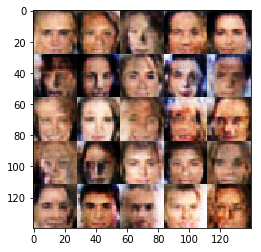

Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.5836
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.9915


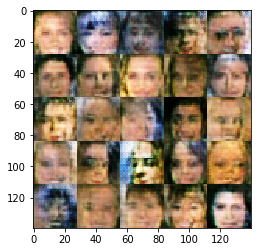

Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.8155


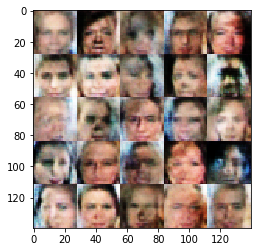

Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6024


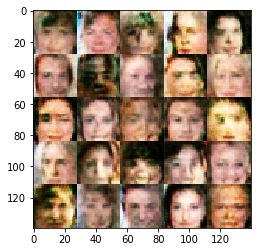

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.4362
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5893


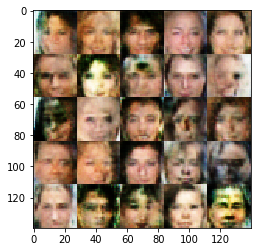

Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.1109


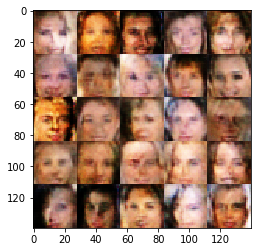

Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.7558


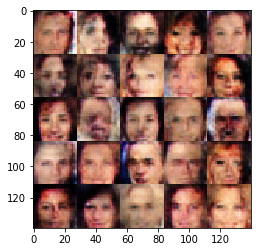

Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.8043


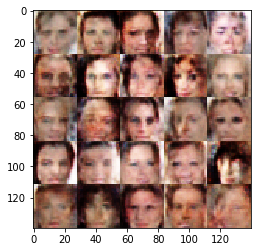

Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.6546


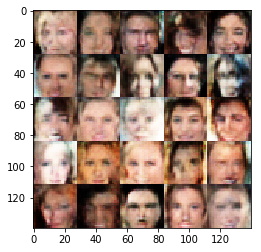

Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6701


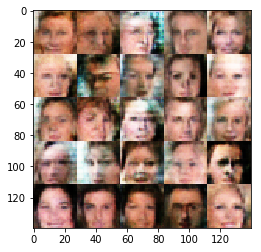

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7439


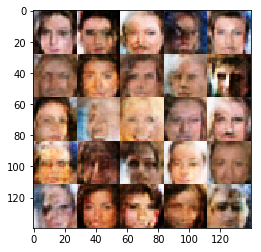

Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6000


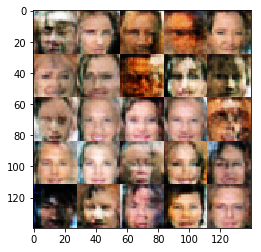

Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.4823
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7468


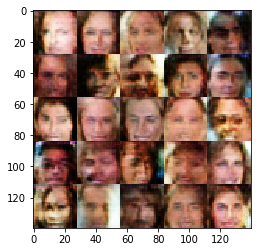

Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.7775


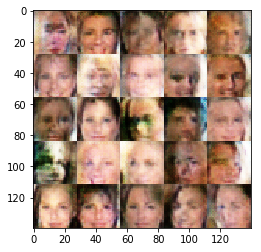

Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.0115


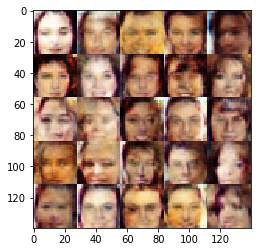

Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.7459


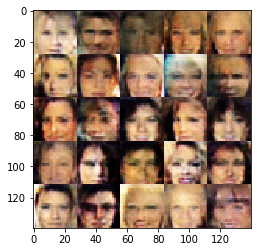

Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.6233... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.6689


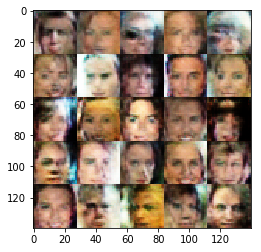

Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5014


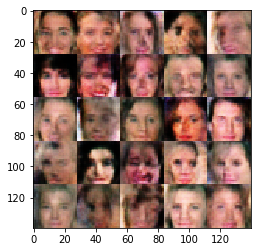

Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5434


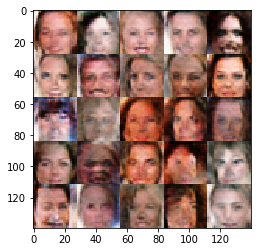

Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.5329... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5436


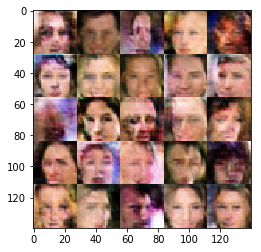

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.6701


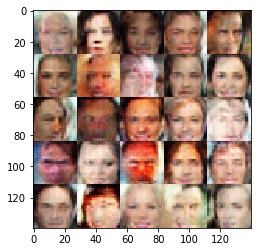

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.6513


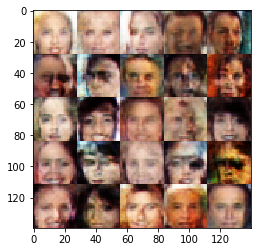

Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4887


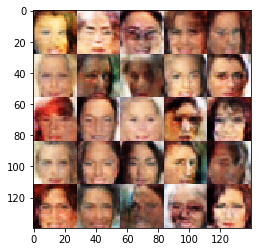

Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.5959


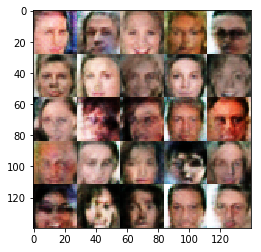

Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.6145


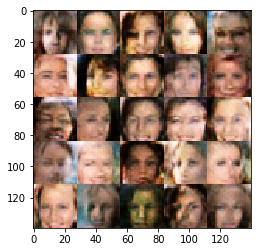

Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7002


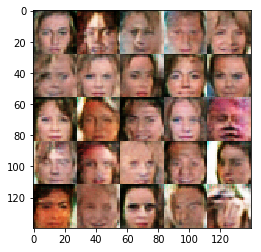

Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.6854


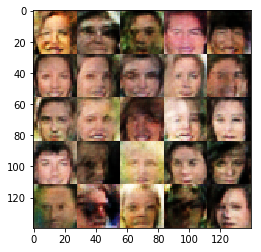

Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7448


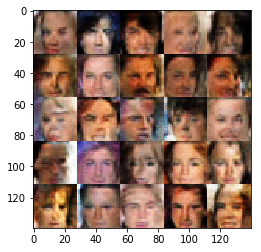

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6954


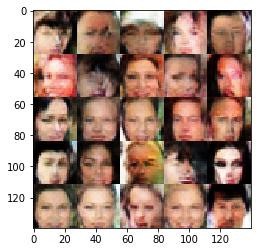

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7120


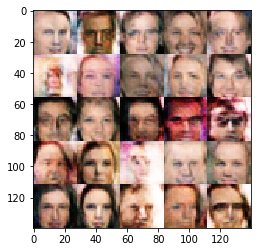

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.5333


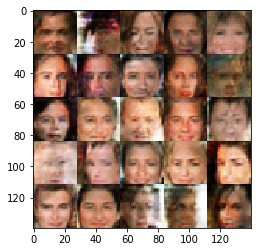

Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6036


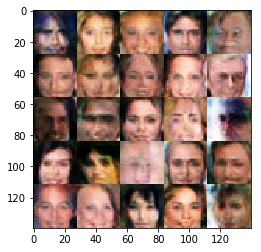

Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.8245


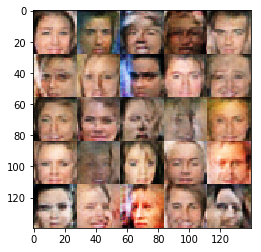

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6091


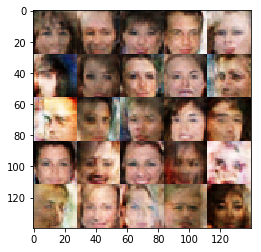

Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.8637


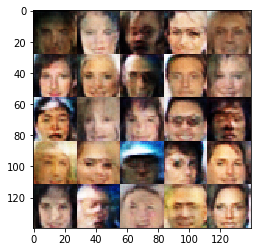

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.5695


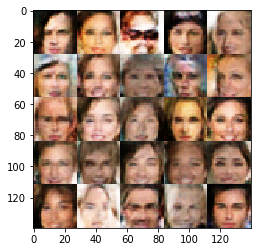

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6453


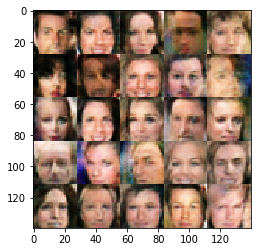

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.7566


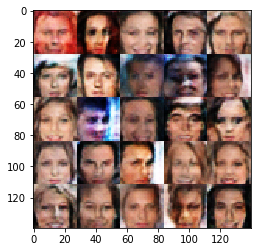

Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5407


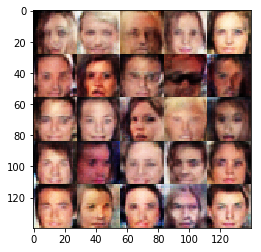

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7001


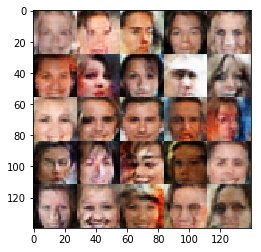

Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7548


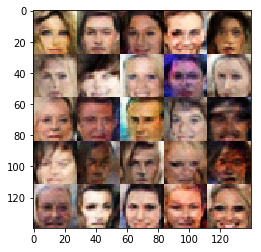

Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6772


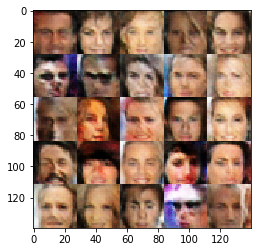

Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7527


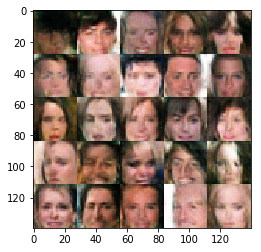

Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.6869


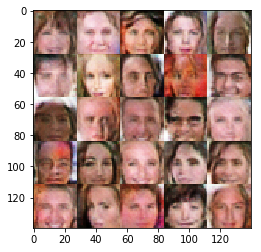

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6897


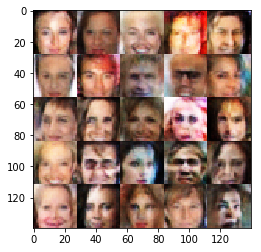

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7102


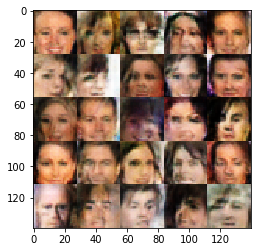

Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7347


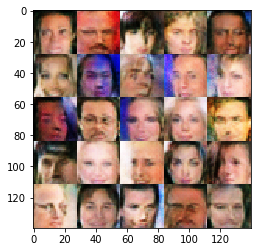

Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.6765


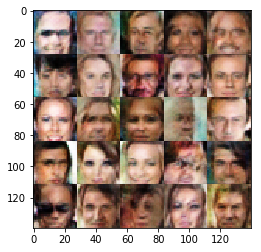

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6516


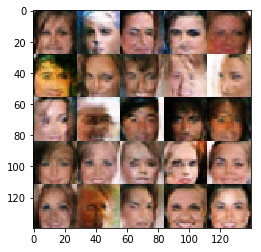

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.6570


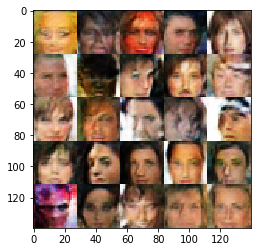

Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5758


In [144]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.